# Demonstrations

## Gradient Boosting Demonstration

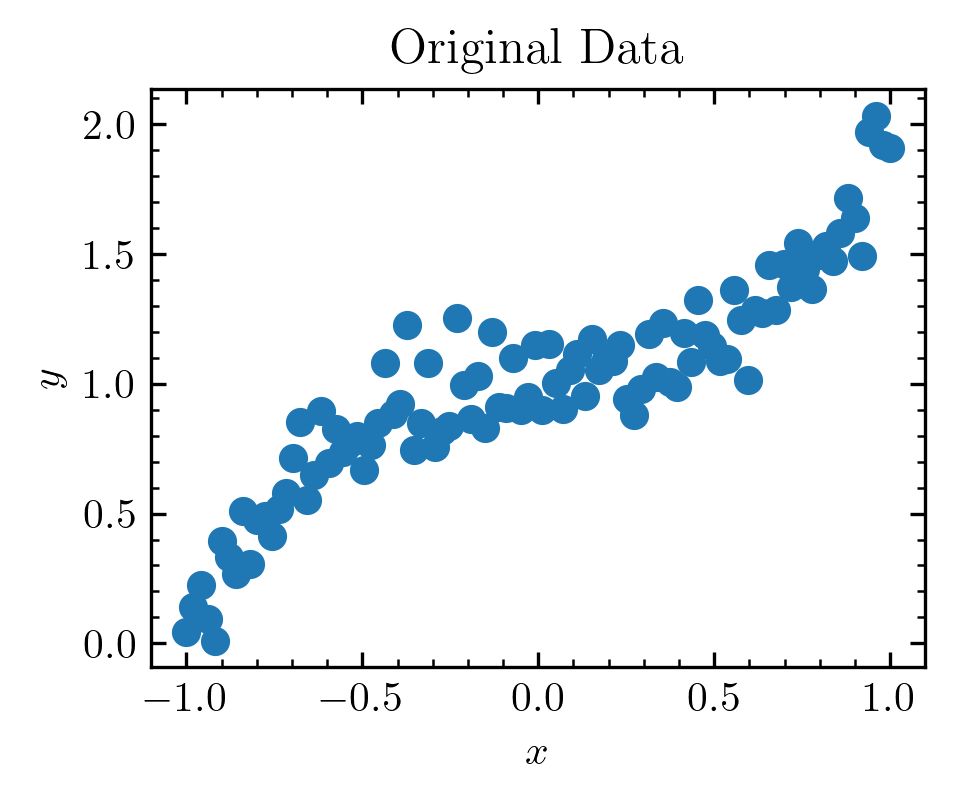

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.ensemble import GradientBoostingRegressor

X = np.linspace(-1, +1, 100).reshape(-1, 1)
y = X[:, 0]**3 + np.random.normal(scale=0.1, size=len(X)) + 1
plt.scatter(X[:, 0], y)
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')
plt.title('Original Data');

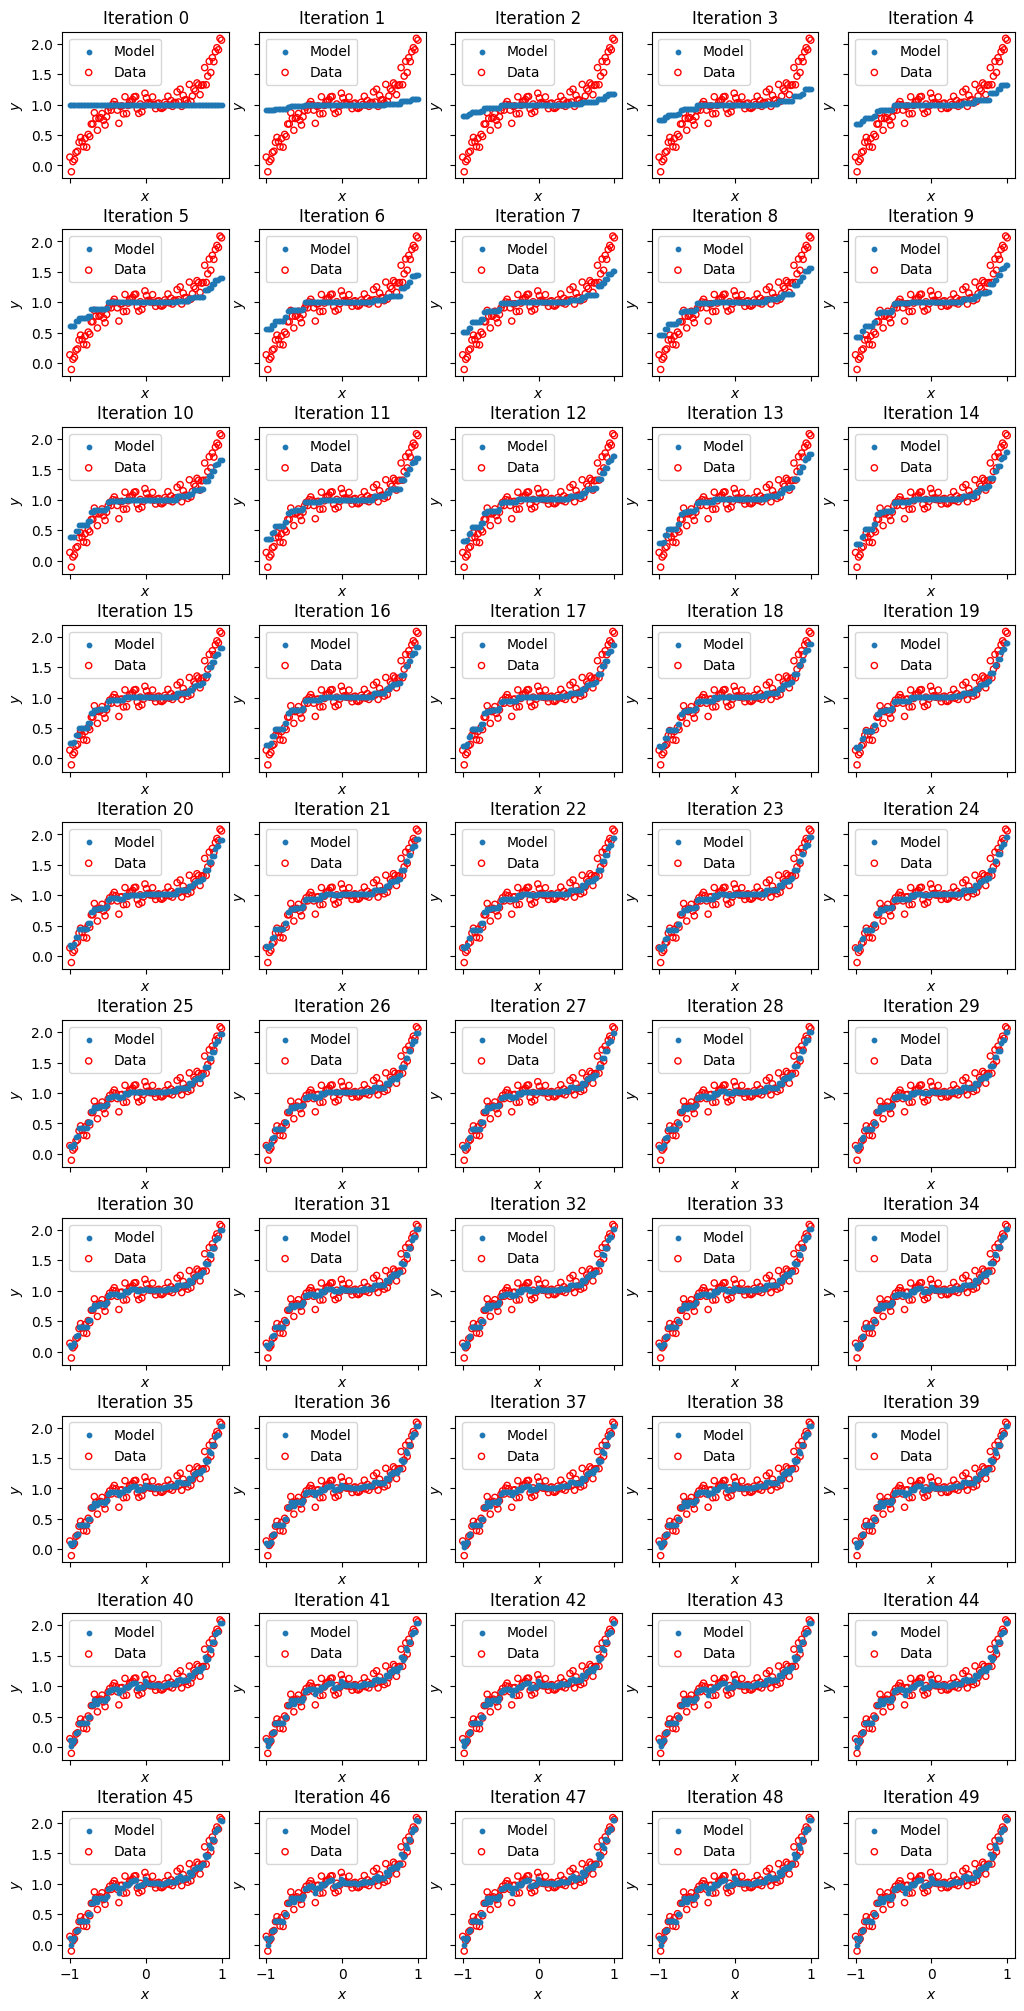

In [5]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.ensemble import GradientBoostingRegressor

X = np.linspace(-1, +1, 100).reshape(-1, 1)
y = X[:, 0]**3 + np.random.normal(scale=0.1, size=len(X)) + 1

gb_1 = GradientBoostingRegressor(learning_rate=0.1, n_estimators=49).fit(X, y)
fig, axs = plt.subplots(figsize=(10, 20), ncols=5, nrows=10, sharex=True, sharey=True)
axs = axs.flatten()

y_pred = np.repeat(np.mean(y), len(X))

for i, ax in enumerate(axs):
    if i > 0:
        y_pred += gb_1.learning_rate * gb_1.estimators_[i - 1][0].predict(X)
    ax.scatter(X[:, 0], y_pred, s=10, label='Model')
    ax.scatter(X[:, 0], y, fc='none', ec='red', zorder=-1, s=20, label='Data')
    ax.set_xlabel(r'$x$')
    ax.set_ylabel(r'$y$')
    ax.set_ylim(axs[0].get_ylim())
    if i == len(axs) - 1:
        # Check that we correctly make predictions from individual trees.
        assert np.allclose(y_pred, gb_1.predict(X))
    ax.set_title(f'Iteration {i}')
    ax.legend(loc='best')

plt.tight_layout(pad=0.3)

## Training Curve

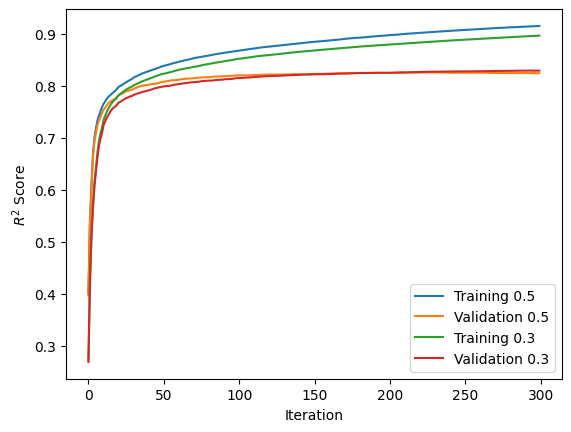

In [10]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.datasets import fetch_california_housing
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import r2_score
from sklearn.model_selection import KFold

X, y = fetch_california_housing(return_X_y=True)
n_splits = 5

for learning_rate in [0.5, 0.3]:
    gb = GradientBoostingRegressor(n_estimators=300, learning_rate=learning_rate)
    train_r2 = np.zeros(gb.n_estimators)
    test_r2 = np.zeros(gb.n_estimators)

    for train_idx, test_idx in KFold(shuffle=True, n_splits=n_splits).split(X):
        gb.fit(X[train_idx], y[train_idx])
        for idx, r2 in zip([train_idx, test_idx], [train_r2, test_r2]):
            for i, y_pred in enumerate(gb.staged_predict(X[idx])):
                r2[i] += r2_score(y[idx], y_pred) / n_splits


    plt.plot(train_r2, label=f'Training {learning_rate:0.1f}')
    plt.plot(test_r2, label=f'Validation {learning_rate:0.1f}')

plt.xlabel('Iteration')
plt.ylabel(r'$R^2$ Score')
plt.legend(loc='best');

## Early Stopping

As you can see above, more iterations (number of trees) most often increases the training score but may not benefit the validation score. In fact, beyond a certain number of trees wer experience overfitting where the algorithm "memorizes" the training data. Early stopping addresses by monitoring the validation score during training. If we validation score does not improve over a certain number of iterations, we stop adding new trees. An added bonus is also that training is computationally less expensive.

In [4]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.datasets import fetch_california_housing

X, y = fetch_california_housing(return_X_y=True)
gb_1 = GradientBoostingRegressor(n_estimators=300, learning_rate=0.5,
                                 n_iter_no_change=10, validation_fraction=0.1)
gb_1.fit(X, y)
print(f"Trees: {gb_1.n_estimators_}/{gb_1.n_estimators}")

Trees: 89/300


## Speeding Up Gradient Boosting

Because gradient boosting is a sequential ensemble learning method, where each tree corrects the errors of the previous ones, we cannot parallelize training. (The evaluation, though, can be parallelized.) This makes gradient boosting computationally expensive. One way to address this issue is by making the training of decision trees faster. `sklearn.ensemble.HistGradientBoostingRegressor` implements a few clever tricks to do just that. These tricks are also the basis for many popular and successful machine learning codes such as XGBoost.

In [5]:
import numpy as np

from sklearn.datasets import fetch_california_housing
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.model_selection import cross_val_score, KFold
from time import time
from sklearn.neural_network import MLPRegressor

X, y = fetch_california_housing(return_X_y=True)
for gb_1 in [GradientBoostingRegressor(),
             HistGradientBoostingRegressor()]:
    print(type(gb_1).__name__)
    t_start = time()
    score = cross_val_score(gb_1, X, y, n_jobs=-1, cv=KFold(
        10, shuffle=True, random_state=42))
    t_end = time()
    print(f"Score: {score.mean():.3f} +/- {score.std() / np.sqrt(len(score)):.3f}")
    print(f"Compute Time: {t_end - t_start:.1f}s")

GradientBoostingRegressor
Score: 0.788 +/- 0.004
Compute Time: 16.1s
HistGradientBoostingRegressor
Score: 0.837 +/- 0.003
Compute Time: 1.5s


# Exercise

Let's return to the California housing data set that we previously studied with random forests and linear regression. As before, the goal is to predict the median house value based on $8$ other predictive attributes. To speed up this exercise, please use `sklearn.ensemble.HistGradientBoostingRegressor`.

(a) Optimize the hyperparameters of the gradient boosting regressor using cross-validation. What are the (near) optimal parameters and score? How does the cross-validation score compare the near-optinal random forest (`max_features='log2'`, all other parameters default)?

(b) Plot the training curve of the best-fitting gradient boosting regressor. (Hint: Unlike `sklearn.ensemble.GradientBoostingRegressor`, `sklearn.ensemble.HistGradientBoostingRegressor` carries the training and validation scores in the `train_score_` and `validation_score_` attributes.)

(c) Plot the feature importance of the default `sklearn.ensemble.GradientBoostingRegressor` and compare it to that of the best-fitting random forest. (`sklearn.ensemble.HistGradientBoostingRegressor` does not have the `feature_importances_` attribute.)

,early_stopping,max_iter,max_depth,learning_rate,mean_test_score,rank_test_score,std_test_score
5,True,250,6,0.1,0.843381,1,0.011747
9,True,250,5,0.2,0.843119,2,0.011098
11,True,250,6,0.2,0.841773,3,0.012538
3,True,250,5,0.1,0.841178,4,0.011846
10,True,100,6,0.2,0.839875,5,0.011326
7,True,250,4,0.2,0.837547,6,0.013608
8,True,100,5,0.2,0.835899,7,0.012916
1,True,250,4,0.1,0.832751,8,0.012892
4,True,100,6,0.1,0.831182,9,0.011312
6,True,100,4,0.2,0.827448,10,0.013065


[-0.66914997 -0.59476914 -0.533824   -0.48280615 -0.43967977 -0.4046577
 -0.37482152 -0.34910743 -0.32676774 -0.30881282 -0.29220913 -0.277852
 -0.26486772 -0.25426823 -0.24435808 -0.23388852 -0.22355474 -0.21671551
 -0.2099437  -0.20502897 -0.20033004 -0.19589761 -0.19091533 -0.18666361
 -0.18222624 -0.17860423 -0.1757481  -0.17270474 -0.16798321 -0.16595258
 -0.16362252 -0.16175614 -0.15797669 -0.15624402 -0.15379075 -0.15070543
 -0.14927317 -0.14822091 -0.14726036 -0.14510577 -0.14407209 -0.143296
 -0.14182394 -0.14108466 -0.14024447 -0.13895965 -0.13806191 -0.13706741
 -0.1358639  -0.13463073 -0.13398063 -0.13348702 -0.13292061 -0.13236899
 -0.13198992 -0.13075338 -0.12928759 -0.12872857 -0.12817419 -0.12756172
 -0.12727241 -0.12685938 -0.12640869 -0.12593897 -0.12535986 -0.12434571
 -0.12397845 -0.12360141 -0.12217536 -0.12155138 -0.12123956 -0.12016783
 -0.11997571 -0.11973486 -0.11948534 -0.119071   -0.11868714 -0.11830651
 -0.11814727 -0.11776059 -0.11753799 -0.1172812  -0.1167

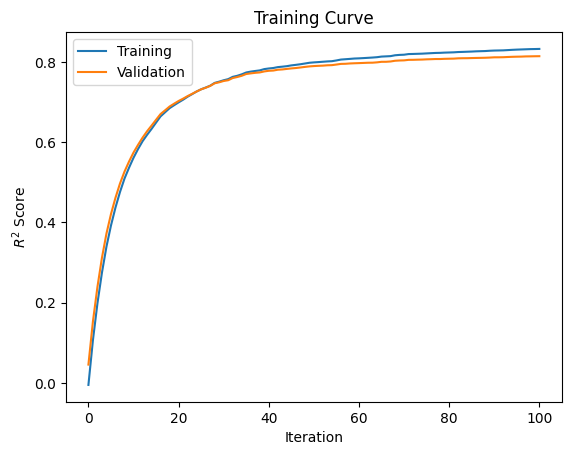

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_california_housing
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.model_selection import GridSearchCV, KFold

# load the data as X and y for easy use with sklearn
X, y = fetch_california_housing(return_X_y=True)

gb = HistGradientBoostingRegressor()
kfold = KFold(10, shuffle=True, random_state=0)
param_grid = dict(early_stopping = [True],
                  max_iter = [100, 250],
                  max_depth = range(4, 7),
                  learning_rate = np.linspace(0.1, 0.2, 2))
model = GridSearchCV(gb, param_grid= param_grid, cv = kfold, scoring='r2', return_train_score=True, n_jobs=-1).fit(X, y)

df = pd.DataFrame(model.cv_results_)
results = df.rename(columns={f'param_{param}' : param for param in param_grid.keys()})
results = results[[param for param in param_grid.keys()] + ['mean_test_score', 'rank_test_score', 'std_test_score']]
results = results.sort_values(by='rank_test_score')
display(results)


kwargs = df['params'][np.argmax(results['mean_test_score'] * results['early_stopping'])]
gb = HistGradientBoostingRegressor(**kwargs).fit(X, y)

plt.title('Training Curve')
plt.xlabel('Iteration')
plt.ylabel(r'$R^2$ Score')
plt.plot(1 - (-2 * gb.train_score_) / np.var(y), label='Training')
plt.plot(1 - (-2 * gb.validation_score_) / np.var(y), label='Validation')
plt.legend(loc='best')